In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.1


In [2]:
seed = 21

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Dataset folders 
dataset_dir = '/notebooks/datasetBea'
training_dir = "/notebooks/datasetBea/train"
validation_dir = "/notebooks/datasetBea/val"

In [4]:
# All the categories to classify the dataset
labels = ['Species1',              # 0
          'Species2',          # 1
          "Species3",             # 2
          "Species4",          # 3
          "Species5",            # 4
          "Species6",             # 5
          "Species7",         # 6
          "Species8"]             # 7

In [5]:
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=10,
                                        width_shift_range=10,
                                        zoom_range=0.3,
                                        shear_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=labels, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=128,
                                                       shuffle=True,
                                                       seed=seed)

valid_data_gen = ImageDataGenerator(rescale=1/255.)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=True,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [6]:
def get_next_batch(generator):
  batch = next(generator)
    
  print("batch \n")
  #print(batch)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]*255
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

batch 

(Input) image shape: (128, 96, 96, 3)
Target shape: (128, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2


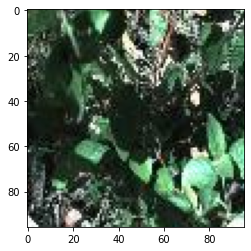

In [7]:
# Get a sample from dataset and show info
_ = get_next_batch(valid_gen)

In [8]:
class_weights = {0: 2.389358108108108, 
                 1: 0.8320588235294117, 
                 2: 0.8583131067961165, 
                 3: 0.8667279411764706, 
                 4: 0.8340212264150944, 
                 5: 1.9978813559322033, 
                 6: 0.8243006993006993, 
                 7: 0.8709975369458128}

In [9]:
epo = 200
init_lr = 1e-3
bs = 256
image_dims = (96, 96, 3)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg19
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam




base_model1 = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    
for layer in base_model1.layers[:15]: 
    layer.trainable = False 

for layer in base_model1.layers[15:]: 
    layer.trainable = True
    
inputs=tfk.Input(shape=(96,96,3))
#x = tfk.layers.Resizing(96,96,interpolation="bicubic")(inputs) 
#x=base_model1(x)  
x = base_model1(inputs)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(128,activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

model1 = Model(inputs=inputs, outputs=outputs)
print (model1.summary())

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                              

In [11]:
opt = Adam(learning_rate=init_lr)
model1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])    
cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
               tf.keras.callbacks.ModelCheckpoint(filepath='/notebooks/model_checkpoints/vgg19.h5',verbose=1,monitor='val_accuracy', save_best_only=True, mode='max'),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]
#load model
#filepath="/content/drive/MyDrive/models/model3.18-0.11.h5"
#model1=load_model(filepath)

# Train the model with the new callback

hist1 = model1.fit(aug_train_gen,
                 epochs=epo,
                 validation_data=valid_gen,
                 class_weight= class_weights,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training


Epoch 1/200
23/23 [==============================] - ETA: 0s - loss: 2.2999 - accuracy: 0.1417
Epoch 1: val_accuracy improved from -inf to 0.15007, saving model to /notebooks/model_checkpoints/vgg19.h5
23/23 [==============================] - 17s 385ms/step - loss: 2.2999 - accuracy: 0.1417 - val_loss: 2.0797 - val_accuracy: 0.1501
Epoch 2/200
23/23 [==============================] - ETA: 0s - loss: 2.0866 - accuracy: 0.1449
Epoch 2: val_accuracy did not improve from 0.15007
23/23 [==============================] - 8s 326ms/step - loss: 2.0866 - accuracy: 0.1449 - val_loss: 2.0794 - val_accuracy: 0.1501
Epoch 3/200
23/23 [==============================] - ETA: 0s - loss: 2.0797 - accuracy: 0.1499
Epoch 3: val_accuracy did not improve from 0.15007
23/23 [==============================] - 8s 341ms/step - loss: 2.0797 - accuracy: 0.1499 - val_loss: 2.0802 - val_accuracy: 0.1501
Epoch 4/200
23/23 [==============================] - ETA: 0s - loss: 2.0797 - accuracy: 0.1499
Epoch 4: val_accu

In [15]:
print (hist1)
import pickle
model1.save("model_bea_base_mauri_vggScolastico3")
with open('trainhist1', 'wb') as file_pi:
      pickle.dump(hist1, file_pi)

INFO:tensorflow:Assets written to: model_bea_base_mauri_vggScolastico3/assets


INFO:tensorflow:Assets written to: model_bea_base_mauri_vggScolastico3/assets


INFO:tensorflow:Assets written to: ram://63d369d8-b1c1-46d9-9372-4e084c363438/assets


INFO:tensorflow:Assets written to: ram://63d369d8-b1c1-46d9-9372-4e084c363438/assets


batch 

(Input) image shape: (256, 96, 96, 3)
Target shape: (256, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2
8/8 [==============================] - 1s 19ms/step


<AxesSubplot:>

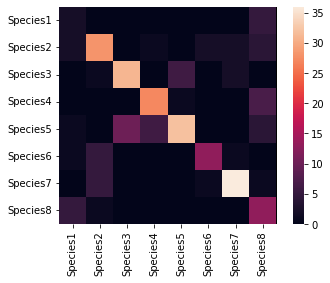

In [16]:
x,y=get_next_batch(valid_gen)
predictions=model1.predict(x)
predictions.shape
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
sns.heatmap(cm.T,xticklabels=list(labels), yticklabels=list(labels))


In [ ]:
hist1 = pickle.load(open('trainhist1', "rb"))
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist1.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist1.history['accuracy'], epoch_list, hist1.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

epoch_list = list(range(1, len(hist1.history['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist1.history['loss'], epoch_list, hist1.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()